### Tweet Hashtag Reccomendation

In [24]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.modules.distance import CosineSimilarity
import torch.optim as optim
#import torch.nn.functional as F
import numpy as np
# import nltk
import random
import numpy as np
# from collections import Counter, OrderedDict
import json, random
from gensim.models import Word2Vec
# from copy import deepcopy

In [25]:
#flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

print(torch.__version__)

try:
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))
except Exception as e:
    print(e)

0.4.1
0
GeForce GTX 1050 Ti


In [26]:
def generate_data(min_words=6, max_words=18, max_tweets = None):
    tweet_data_filename = "./data/processed_tweets.json"
    largest_tweet = ""
    len_largest_tweet = -1

    filtered_tweets = []

    with open(tweet_data_filename) as json_handle:
        tweets = json.load(json_handle)['data']
        i = 1;
        for tweet in tweets:
            if tweet["num_words"] >= min_words and tweet["num_words"] <= max_words:
                filtered_tweets.append(tweet)
                i += 1
            if max_tweets is not None and i > max_tweets: 
                break

    for tweet in filtered_tweets:
        if tweet["num_words"] > len_largest_tweet:
            len_largest_tweet = tweet["num_words"]
            largest_tweet = tweet["tweet"]

    print("Largest filtered tweet: ", len_largest_tweet)
    
    for tweet in filtered_tweets:
        while tweet["num_words"] < len_largest_tweet:
            tweet["tweet"] += " <null/>"
            tweet["num_words"] += 1

    return filtered_tweets

In [27]:
data = generate_data(max_tweets = 1000)

Largest filtered tweet:  18


In [28]:
def word_2_vec(data):
    collect_tweet = []
    
    for datum in data:
        collect_tweet.append(datum["tweet"].split(' '))
        collect_tweet.append([datum["hashtag"]])
    
    #print(collect_tweet[211*2 + 1])
    #print(data[211])
    
    model = Word2Vec(
        collect_tweet,
        size = WORD2VEC_DIM,
        sg = 1,
        min_count = 0,
        workers = 10
    )
    
    model.train(collect_tweet, total_examples=len(collect_tweet), epochs=10)
    model.save("./model/word2vec/word2vec.bin")
    
    return model

In [29]:
WORD2VEC_DIM = 128
LOAD_WORD2VEC = False

if LOAD_WORD2VEC:
    word2vec_model = Word2Vec.load("./model/word2vec/word2vec.bin")
else:
    word2vec_model = word_2_vec(data)
    
print(word2vec_model)

Word2Vec(vocab=2916, size=128, alpha=0.025)


https://radimrehurek.com/gensim/models/word2vec.html

The trained word vectors are stored in a KeyedVectors instance in model.wv: if we do not use .wv and directly access a word like model["ambulance"] we would get a Deprecated warning

/home/svh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

In [30]:
print(word2vec_model.wv[data[0]["tweet"].split()].shape)

(18, 128)


do not use split(" ") to split the tweet into words since there might be addtional spaces between words within a given tweet <br/>
split() method automatically removes additional spaces between words and this is crucial for our database and we did not preprocess the tweet to remove additional soaces between words

In [31]:
X, y = [], []
for tweet_obj in data:
    X.append(word2vec_model.wv[tweet_obj["tweet"].split()])
    y.append(word2vec_model.wv[tweet_obj["hashtag"]])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1000, 18, 128) (1000, 128)


https://pytorch.org/docs/stable/data.html

https://am207.github.io/2018spring/wiki/ValidationSplits.html

https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN

In [32]:
from torch.utils.data import *

BATCH_SIZE = 100

tweet_dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))

TRAIN_TEST_SPLIT = 0.90
TRAIN_VAL_SPLIT = 0.85 

db_len = tweet_dataset.__len__() 
train_len = int(db_len * TRAIN_TEST_SPLIT)
test_len = db_len - train_len

val_len = int(train_len * (1.0 - TRAIN_VAL_SPLIT))
train_len = train_len  - val_len 

print(train_len, val_len, test_len)

train_ds, val_ds, test_ds = random_split(tweet_dataset, [train_len, val_len, test_len])


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

"""
for epoch in range(1):   
    for batch_index, (X, y) in enumerate(train_loader):
        print(epoch, batch_index, X.shape, y.shape)
        break
"""

"""
Sample Output
9180 1620 1200
0 0 torch.Size([16, 18, 150]) torch.Size([16, 150])
"""

765 135 100


'\nSample Output\n9180 1620 1200\n0 0 torch.Size([16, 18, 150]) torch.Size([16, 150])\n'

In [45]:
# TODO: cross check with satya to remove (if any) redundant class functions 

class BenchmarkModel(nn.Module): 
    def __init__(self, hidden_size, dropout=0.2, input_size = WORD2VEC_DIM, batch_size=16):
        super(BenchmarkModel, self).__init__()
        print("__init__")
        self.num_layers = 1
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        # self.embed = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(input_size, hidden_size
                          , nonlinearity="relu"
                          , dropout=dropout
                          , batch_first=True)
        
        # Warning: I removed dropout
        # UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
        # self.linear = nn.Linear(n_layers, vocab_size)
        
#     def init_weight(self):
#         print("init_weight")
#         self.embed.weight = nn.init.xavier_uniform(self.embed.weight)
#         self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
#         self.linear.bias.data.fill_(0)
        
    # this is called for every forward pass
    def init_hidden(self):
        #print("init_hidden")
        hidden = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        # TODO: why context?
        context = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        return hidden
    
    def detach_hidden(self, hiddens):
        print("detach_hidden")
        return tuple([hidden.detach() for hidden in hiddens])
    
    def forward(self, inputs): 
        # print("Inputs: ", inputs.shape, "Hidden: ", self.hidden.shape)
        out, self.hidden = self.rnn(inputs, self.hidden)
        #print("Out: ", out.shape, " Last Hidden: ", self.hidden.shape)
        #print(out.size())
        out = torch.sum(out, 1)/out.size(1)
        return out

    
class Cosine_Loss(torch.nn.Module):
    def __init__(self):
        super(Cosine_Loss, self).__init__()
        
    def forward(self, x, y):
#         y_shape = y.size()[1]
#         x_added_dim = x.unsqueeze(1)
#         x_stacked_along_dimension1 = x_added_dim.repeat(1,NUM_WORDS,1)
#         diff = torch.sum((y - x_stacked_along_dimension1)**2,2)
#         totloss = torch.sum(torch.sum(torch.sum(diff)))
        return torch.sum(x*y)
        #return nn.MSELoss(x, y)

In [46]:
HIDDEN_SIZE = WORD2VEC_DIM
print(HIDDEN_SIZE)
NUM_LAYER = 18 # should be used for multidimensional RNN is that what Satya was trying to achieve
LR = 0.01
RESCHEDULED = False

128


In [47]:
model = BenchmarkModel(HIDDEN_SIZE, batch_size=BATCH_SIZE)
#loss_function = Cosine_Loss()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

__init__


/home/svh/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [50]:
loss_hist = []
EPOCH = 1000
#hidden = model.init_hidden()

def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

hidden = model.init_hidden()
for epoch in range(EPOCH):
    loss = None
    for batch_index, (X, y) in enumerate(train_loader):
        # X.shape --> (batch_size, num_of_words_per_tweet, word2vec_dim)
        # y.shape --> (batch_size, word2vec_dim)
        
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        #hidden = repackage_hidden(hidden)
        hidden = repackage_hidden(model.hidden)
        model.hidden = hidden
        # Step 2. forward pass.
        y_pred = model(X)
        
        
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(y_pred, y)
        #print("Epoch {:03d}, Batch {:03d}, Loss {:5.4f}".format(epoch, batch_index, loss.item()))
        model.zero_grad()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)
        loss.backward(retain_graph=True)
        optimizer.step()
    
    loss_hist.append(loss.item())    
    print("Epoch {:03d}, Loss {:5.4f}".format(epoch, loss.item()))

TypeError: iteration over a 0-d tensor

In [23]:

for epoch in range(1):
    loss = None
    for batch_index, (X, y) in enumerate(train_loader):
        # X.shape --> (batch_size, num_of_words_per_tweet, word2vec_dim)
        # y.shape --> (batch_size, word2vec_dim)
        print(X.shape)
        print(y.shape)

torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])
torch.Size([100, 18, 128])
torch.Size([100, 128])


In [26]:
torch.save(model.state_dict(), "./model/nn/nn.pt")

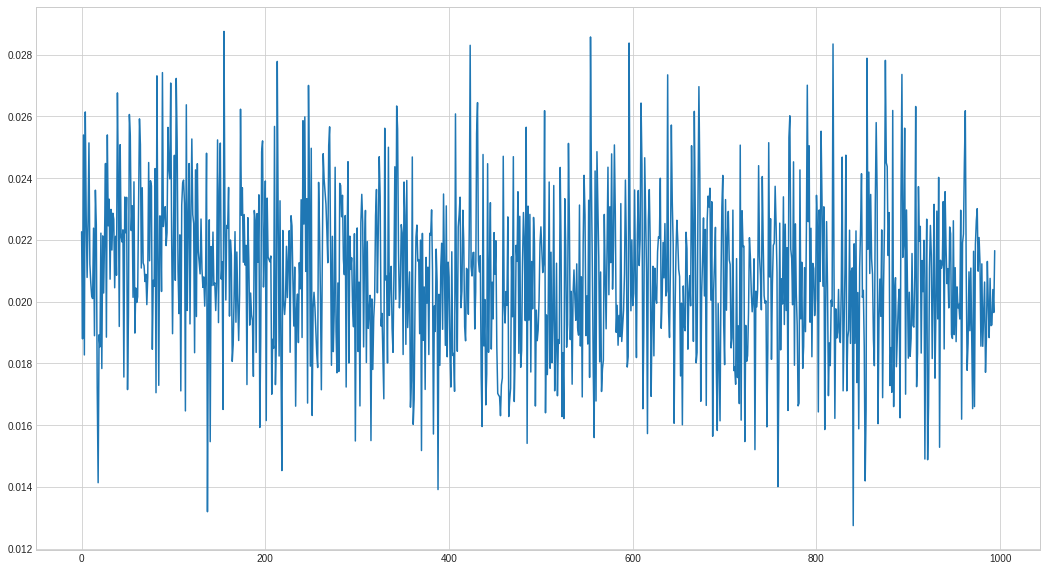

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))

plt.style.use('seaborn-whitegrid')

#plt.plot(range(EPOCH), loss_hist)
plt.plot(range(len(loss_hist[5:])), loss_hist[5:])

plt.savefig('./myfig.png')